# Quasi-Laplace approximation for Poisson data

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]

### About

The [quasi-Laplace approximation]({% post_url 2020-06-22-intuition-for-quasi-Laplace %}) may be extended to approximate the posterior of a Poisson distribution with a Gaussian, as we will see here.
We approximate the regularized likelihood 
$\mathscr{L}_{\mathrm{reg}}(\boldsymbol{\beta})$
defined as the product of the likelihood and a Gaussian *regularizer*,
\begin{equation*}
\mathscr{L}_{\mathrm{reg}}(\boldsymbol{\beta}) \triangleq p\left(\mathbf{y} \mid \mathbf{X}, \boldsymbol{\beta}\right)
\mathcal{N}\left( \boldsymbol{\beta} \mid \mathbf{0}, \mathbf{\Lambda}^{-1} \right) \propto
\mathcal{N}\left( \boldsymbol{\beta} \mid \mathbf{m}, \mathbf{S} \right)
\end{equation*}
such that the mode of the regularized likelihood is near the mode of the posterior.
 
The prior $p\left(\boldsymbol{\beta}\mid g \right)$ is a mixture of Gaussians with known variances but unknown mixture proportions.
The precision matrix $\mathbf{\Lambda}$ is defined as a diagonal matrix, $\mathbf{\Lambda} \triangleq \mathrm{diag}\left(\boldsymbol{\lambda}\right)$, whose elements $\lambda_j$ are roughly set to some expected value to ensure that the regularized likelihood is centered at the mode of the posterior.

In [1]:
#collapse_hide

import numpy as np
np.set_printoptions(precision = 4, suppress=True)

from scipy import optimize
from scipy.special import gammaln
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import ticker as plticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys
sys.path.append("../../utils/")
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt', dpi = 72)

### Generate toy data

Let us consider a Poisson model with sparse coefficients, so that the number of causal variables `ncausal` is much less than the number of variables `nvar` in the model. This is ensured by sampling the betas from a Gaussian mixture prior of `nGcomp` components with variances given by $\sigma_k^2$ (`sigmak2`) and the mixture proportions given by `probk`. The sparsity is controlled by the variable `sparsity` that specifies the mixture proportion of the zero-th component $\mathcal{N}(0, 0)$ (or the delta function).

In [2]:
nsample = 20
nvar = 30
nGcomp = 3
sparsity = 0.8
prior_strength = 20
num_inf = 1e4 # a large number for 1/sigma_k^2 when sigma_k^2 = 0

probk = np.zeros(nGcomp)
probk[0] = sparsity
probk[1:(nGcomp - 1)] = (1 - sparsity) / (nGcomp - 1)
probk[nGcomp - 1] = 1 - np.sum(probk)
sigmak2 = np.array([prior_strength * np.square(np.power(2, (i)/nGcomp) - 1) for i in range(nGcomp)])

We use the exponential link function $\lambda_i = \exp\left(\mathbf{X}_i\boldsymbol{\beta}\right)$ to generate the response variable $y_i$ for $i = 1, \ldots, N$ samples using the Poisson probability distribution
\begin{equation*}
p\left(y_i \mid \mathbf{X}_i, \boldsymbol{\beta}\right) = \frac{\lambda_i^{y_i}e^{-\lambda_i}}{y_i!}
\end{equation*}
$\mathbf{X}$ is centered and scaled such that for each variable $j$, the variance is $\mathrm{var}(\mathbf{x}_j) = 1$.

In [3]:
# collapse-hide

def standardize(X):
    Xnorm = (X - np.mean(X, axis = 0)) 
    Xstd =  Xnorm / np.std(Xnorm, axis = 0)
    return Xstd

def poisson_data(X, beta):
    Xbeta = np.dot(X, beta)
    pred = np.exp(Xbeta)
    Y = np.random.poisson(pred)
    return Y


X = np.random.rand(nsample * nvar).reshape(nsample, nvar)
X = standardize(X)

gammajk = np.random.multinomial(1, probk, size = nvar)
beta = np.zeros(nvar)
for j in range(nvar):
    if gammajk[j, 0] != 1:
        kidx = np.where(gammajk[j, :] == 1)[0][0]
        kstd = np.sqrt(sigmak2[kidx])
        beta[j] = np.random.normal(loc = 0., scale = kstd)

ncausal = beta[beta != 0].shape[0]
betavar = np.var(beta[beta != 0])

Y = poisson_data(X, beta)

Let us have a look at the generated data.

There are 5 non-zero coefficients with variance 3.2003


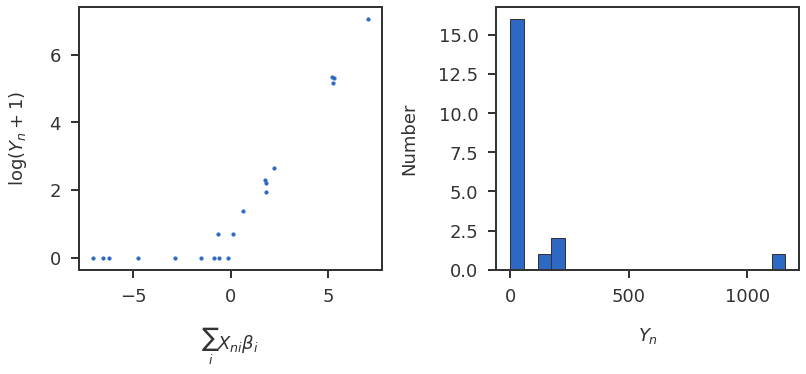

In [4]:
# collapse-hide

print(f'There are {ncausal} non-zero coefficients with variance {betavar:.4f}')

fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

Xbeta = np.dot(X, beta)
ax1.scatter(Xbeta, np.log(Y+1), s = 10)
ax2.hist(Y)

ax1.set_xlabel(r'$\sum_i X_{ni} \beta_i$')
ax1.set_ylabel(r'$\log(Y_n + 1)$')
ax2.set_xlabel(r'$Y_n$')
ax2.set_ylabel('Number')
plt.tight_layout(pad = 2.0)
plt.show()

### True posterior vs quasi-Laplace posterior

We select two causal variables (with maximum effect size) and fix all the others to optimum values to understand how the likelihood and posterior depends on these two chosen variables. To avoid the sum over the indicator variables, we use the joint prior $p\left(\boldsymbol{\beta}, \boldsymbol{\gamma} \mid g\right)$.

Some useful function definitions:

In [5]:
# collapse-hide

def get_log_likelihood(Y, X, beta):
    Xbeta = np.dot(X, beta)
    logL = np.sum(Y * Xbeta - np.exp(Xbeta))# - gammaln(Y+1))
    return logL

def get_log_prior(beta, gammajk, probk, sigmak2):
    logprior = 0
    for j, b in enumerate(beta):
        k = np.where(gammajk[j, :] == 1)[0][0]
        logprior += np.log(probk[k])
        if k > 0:
            logprior += - 0.5 * (np.log(2 * np.pi) + np.log(sigmak2[k]) + b * b / sigmak2[k]) 
    return logprior

def plot_contours(ax, X, Y, Z, beta, norm, cstep = 10, zlabel = ""):
    zmin = np.min(Z) - 1 * np.std(Z)
    zmax = np.max(Z) + 1 * np.std(Z)
    ind = np.unravel_index(np.argmax(Z, axis=None), Z.shape)

    levels = np.linspace(zmin, zmax, 200)
    clevels = np.linspace(zmin, zmax, 20)
    cmap = cm.YlOrRd_r

    if norm:
        cset1 = ax.contourf(X, Y, Z, levels, norm = norm,
                            cmap=cm.get_cmap(cmap, len(levels) - 1))
    else:
        cset1 = ax.contourf(X, Y, Z, levels,
                            cmap=cm.get_cmap(cmap, len(levels) - 1))
    cset2 = ax.contour(X, Y, Z, clevels, colors='k')
    for c in cset2.collections:
        c.set_linestyle('solid')


    ax.set_aspect("equal")
    ax.scatter(beta[0], beta[1], color = 'blue', s = 100)
    ax.scatter(X[ind[1]], Y[ind[0]], color = 'k', s = 100)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.2)
    cbar = plt.colorbar(cset1, cax=cax)
    ytickpos = np.arange(int(zmin / cstep) * cstep, zmax, cstep)
    cbar.set_ticks(ytickpos)
    if zlabel:
        cax.set_ylabel(zlabel)

    #loc = plticker.AutoLocator()
    #ax.xaxis.set_major_locator(loc)
    #ax.yaxis.set_major_locator(loc)
    
def regularized_log_likelihood(beta, X, Y, L):
    nvar = beta.shape[0]
    Xbeta = np.dot(X, beta)

    ## Function
    llb = np.sum(Y * Xbeta - np.exp(Xbeta))# - gammaln(Y+1))
    #reg = 0.5 * np.sum(np.log(L)) - 0.5 * np.einsum('i,i->i', np.square(beta), L)
    reg = - 0.5 * np.einsum('i,i->i', np.square(beta), L)
    loglik = llb + reg
    
    ## Gradient
    pred = 1 / (1 + np.exp(-Xbeta))
    der = np.einsum('i,ij->j', Y, X) - np.einsum('ij, i->j', X, np.exp(Xbeta)) - np.multiply(beta, L)
    
    return -loglik, -der

def precisionLL(X, beta, L):
    nvar = X.shape[1]
    Xbeta = np.dot(X, beta)
    pred = np.exp(Xbeta)
    hess = - np.einsum('i,ij,ik->jk', pred, X, X)
    hess[np.diag_indices(nvar)] -= L
    return -hess

def get_mS(X, Y, beta0, L):
    nvar = X.shape[1]
    args  = X, Y, L

    gmode = optimize.minimize(regularized_log_likelihood,
                              beta0,
                              args=args,
                              method='L-BFGS-B',
                              jac=True,
                              bounds=None,
                              options={'maxiter': 20000000,
                                       'maxfun': 20000000,
                                       'ftol': 1e-9,
                                       'gtol': 1e-9
                                       #'disp': True
                                      })
    
    M = gmode.x
    Sinv = precisionLL(X, M, L)
    return M, Sinv

def get_qL_log_posterior(beta, L, M, Sinv, logdetSinv, logprior):
    blessM = beta - M
    bMSbM = np.dot(blessM.T, np.dot(Sinv, blessM))
    bLb = np.einsum('i, i', np.square(beta), L)
    logdetLinv = - np.sum(np.log(L))
    logposterior = 0.5 * (logdetSinv + logdetLinv - bMSbM + bLb)
    logposterior += logprior
    return logposterior

We calculate the likelihood, prior, *true* posterior and the quasi-Laplace posterior. Note that the posteriors are not normalized. We apply quasi-Laplace (QL) approximation with some $\mathbf{\Lambda}$ and show QL posterior distribution, which is given by
\begin{equation*}
p\left(\mathbf{y} \mid \mathbf{X}, \boldsymbol{\beta}\right) p\left(\boldsymbol{\beta}\mid g \right)
\propto
\frac{\mathcal{N}\left( \boldsymbol{\beta} \mid \mathbf{m}, \mathbf{S} \right)
      p\left(\boldsymbol{\beta}\mid g \right)
     }{
      \mathcal{N}\left( \boldsymbol{\beta} \mid \mathbf{0}, \mathbf{\Lambda}^{-1} \right)
     }
\end{equation*}
Here, we assume that we know $\mathbf{\Lambda}$. In reality, we will not know $\mathbf{\Lambda}$ but will have to learn it from the data or make some educated guess from the prior choice.

In [13]:
np.max(beta)

2.2971351695800903

In [16]:
# collapse-hide

bchoose = np.argsort(abs(beta))[-2:]
nplotx = 20
nploty = 20

b1min = -0.5
b1max = 4
b2min = -4
b2max = 0.5
beta1 = np.linspace(b1min, b1max, nplotx)
beta2 = np.linspace(b2min, b2max, nploty)
logL  = np.zeros((nploty, nplotx))
logPr = np.zeros((nploty, nplotx))
logPs = np.zeros((nploty, nplotx))
logQL = np.zeros((nploty, nplotx))

thisbeta = beta.copy()
mask = np.ones(nvar, bool)
mask[bchoose] = False

true_pi = np.sum(gammajk, axis = 0) / np.sum(gammajk)
#reg = 1 / np.einsum('i,i', true_pi, sigmak2)
#regL = np.repeat(reg, nvar)
regL = np.repeat(num_inf, nvar)
for j, b in enumerate(beta):
    k = np.where(gammajk[j, :] == 1)[0][0]
    if k > 0:
        regL[j] = 1 / sigmak2[k]
M, Sinv = get_mS(X, Y, beta, regL)
sgndetSinv, logdetSinv = np.linalg.slogdet(Sinv)

for i, b1 in enumerate(beta1):
    for j, b2 in enumerate(beta2):
        thisbeta[bchoose] = np.array([b1, b2])
        logL[j, i] = get_log_likelihood(Y, X, thisbeta)
        logPr[j, i] = get_log_prior(thisbeta, gammajk, probk, sigmak2)
        logQL[j, i] = get_qL_log_posterior(thisbeta, regL, M, Sinv, logdetSinv, logPr[j, i])
logPs = logL + logPr

Here, we plot the contour maps. The x and y-axis show the two coefficients $\beta_1$ and $\beta_2$, which we chose to vary. The blue dot shows the coordinates of the true values of $\{\beta_1, \beta_2\}$ and the black dot shows the maximum of the log probabilities. Note how the non-Gaussian *true* posterior is now approximated by a Gaussian QL posterior.

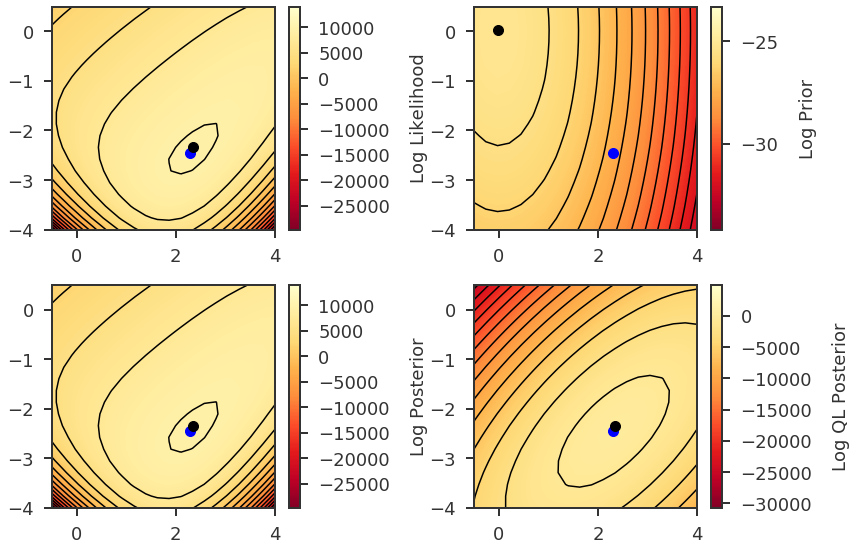

In [20]:
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

norm = cm.colors.Normalize(vmin=np.min(logPs), vmax=np.max(logPs))

plot_contours(ax1, beta1, beta2, logL,  beta[bchoose], None, cstep = 5000, zlabel = "Log Likelihood")
plot_contours(ax2, beta1, beta2, logPr, beta[bchoose], None, cstep = 5,  zlabel = "Log Prior")
plot_contours(ax3, beta1, beta2, logPs, beta[bchoose], None, cstep = 5000, zlabel = "Log Posterior")
plot_contours(ax4, beta1, beta2, logQL,  beta[bchoose], None, cstep = 5000, zlabel = "Log QL Posterior")

plt.tight_layout()
plt.show()

### Effect of regularizer

Let us assume that we do not know $\mathbf{\Lambda}$ and all $\lambda_j$'s are equal. Here we look at how the QL posterior changes with varying $\beta_2$ for different values of $\lambda_j$.

Here we define a function for calculating the QL posterior and true posterior for changing the coefficients of a single variable:

In [21]:
# collapse-hide

def get_logQL_logPs_single_variable(X, Y, beta, regvar, betavar, bidx,
                                    regL, gammajk, probk, sigmak2):

    nvar    = beta.shape[0]
    nplotrv = regvar.shape[0]
    nplotx  = betavar.shape[0]
    logL  = np.zeros(nplotx)
    logPr = np.zeros(nplotx)
    logPs = np.zeros(nplotx)
    logQL = np.zeros((nplotrv, nplotx))

    thisbeta = beta.copy()
    thisL = regL.copy()

    for j, b2 in enumerate(betavar):
        thisbeta[bidx] = b2
        logL[j]  = get_log_likelihood(Y, X, thisbeta)
        logPr[j] = get_log_prior(thisbeta, gammajk, probk, sigmak2)
    logPs = logL + logPr

    for i, r1 in enumerate(regvar):
        thisL = np.repeat(r1, nvar)
        #thisL[bidx] = r1
        M, Sinv = get_mS(X, Y, beta, thisL)
        sgndetSinv, logdetSinv = np.linalg.slogdet(Sinv)
        for j, b2 in enumerate(betavar):
            thisbeta[bidx] = b2
            logQL[i, j] = get_qL_log_posterior(thisbeta, thisL, M, Sinv, logdetSinv, logPr[j])

    return logPs, logQL

And then look at the posteriors for $\beta_2$.

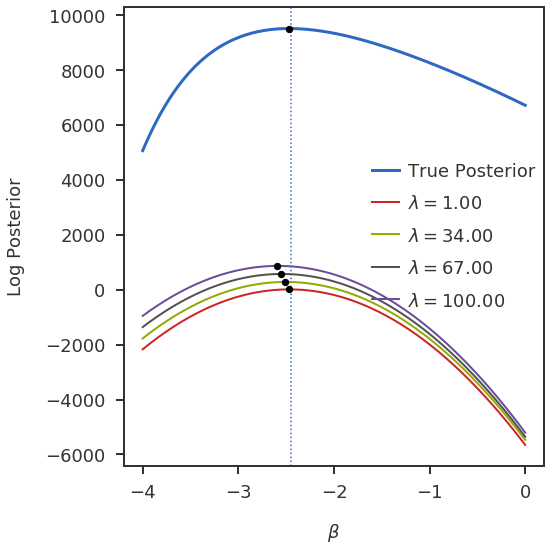

In [22]:
#collapse-hide

nplotx_rv = 200
nplotrv   = 4
bmin = -4
bmax = 0
rvmin  = 1
rvmax  = 100
bidx = bchoose[1]

fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)

betavals = np.linspace(bmin, bmax, nplotx_rv)
regvals  = np.linspace(rvmin, rvmax, nplotrv)
logPs_rv, logQL_rv = get_logQL_logPs_single_variable(X, Y, beta, regvals, betavals, bidx,
                                                     regL, gammajk, probk, sigmak2)

ax1.plot(betavals, logPs_rv, lw = 3, zorder = 2, label = 'True Posterior')
ax1.scatter(betavals[np.argmax(logPs_rv)], logPs_rv[np.argmax(logPs_rv)], s = 40, zorder = 10, color = 'black')
for i, r1 in enumerate(regvals):
    ax1.plot(betavals, logQL_rv[i, :], lw = 2, zorder = 5, label = f'$\lambda =${r1:.2f}')
    ix = np.argmax(logQL_rv[i, :])
    ax1.scatter(betavals[ix], logQL_rv[i, ix], s = 40, zorder = 10, color = 'black')
ax1.axvline(beta[bidx], ls = 'dotted', zorder = 1)

ax1.legend(handlelength = 1.5)
ax1.set_xlabel(r'$\beta$')
ax1.set_ylabel('Log Posterior')
plt.tight_layout()
plt.show()

What happens to the QL posterior for other variables? Let us look at every $\beta_j$ and their individual maximum posterior, while all others are kept fixed at optimum values. Here, we have arranged the $\beta_j$ in ascending order.

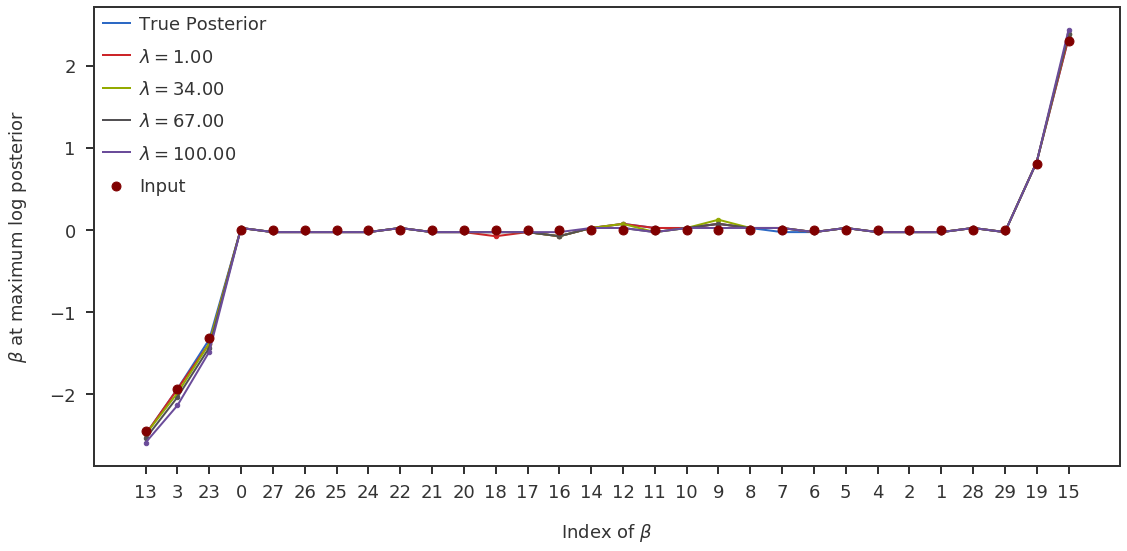

In [23]:
#collapse-hide

bmin = -5
bmax = 5

bidx_sorted = np.argsort(beta)
bidx_sorted_nz = bidx_sorted #bidx_sorted[beta[bidx_sorted]!=0]

betavals = np.linspace(bmin, bmax, nplotx_rv)
regvals  = np.linspace(rvmin, rvmax, nplotrv)

maxQL = np.zeros((nplotrv, len(bidx_sorted_nz)))
maxPs = np.zeros(len(bidx_sorted_nz))
for i, bidx in enumerate(bidx_sorted_nz):
    _logPs, _logQL = get_logQL_logPs_single_variable(X, Y, beta, regvals, betavals, bidx,
                                                         regL, gammajk, probk, sigmak2)
    maxPs[i] = betavals[np.argmax(_logPs)]
    for j in range(len(regvals)):
        maxQL[j, i] = betavals[np.argmax(_logQL[j, :])]
        
fig = plt.figure(figsize = (16, 8))
ax1 = fig.add_subplot(111)

xvals = np.arange(len(bidx_sorted_nz))

ax1.plot(xvals, maxPs, lw = 2, zorder = 2, label = 'True Posterior')
for i, r1 in enumerate(regvals):
    ax1.plot(xvals, maxQL[i, :], lw = 2, zorder = 5, label = f'$\lambda =${r1:.2f}')
    
ax1.scatter(xvals, maxPs, s = 20, zorder = 1)
for i, r1 in enumerate(regvals):
    ax1.scatter(xvals, maxQL[i, :], s = 20, zorder = 1)
ax1.scatter(xvals, beta[bidx_sorted_nz], s = 80, zorder = 10, color = 'maroon', label = 'Input')

ax1.legend(handlelength = 1.5)
ax1.set_xlabel(r'Index of $\beta$')
ax1.set_ylabel(r'$\beta$ at maximum log posterior')
ax1.set_xticks(xvals)
ax1.set_xticklabels([f'{idx}' for idx in bidx_sorted_nz])

plt.tight_layout()
plt.show()